In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import re
from tqdm import tqdm
import time


# Load the .env file
load_dotenv()

df = pd.read_csv('Data/contrarian_claims_reasons.csv')

In [2]:
df

,text_id,text,original_code,replicated_code,model_code,reason
0,0,The Food and Drug Administrations seeks input ...,0.0,0.0,0.0,0.0 - This text is not related to climate chan...
1,1,Has the globe warmed? Most think that since th...,5.1,5.1,5.1,Reasoning: The text questions the reliability ...
2,2,The Heartland Institute is a 27-year-old natio...,0.0,0.0,0.0,Reasoning: The text does not contain any state...
3,3,Interesting facts were revealed in this articl...,0.0,0.0,0.0,The text is not related to climate change or a...
4,4,"""The government is mobilized to find the truth...",0.0,5.3,0.0,0.0 - This text does not relate to any of the ...
...,...,...,...,...,...,...
95,95,How do theyattributethe heatwave to global war...,5.1,5.1,5.1,The statement questions the attribution of a h...
96,96,It's remarkable that she doesn't even dare to ...,0.0,5.1,5.2,Reasoning: The text is criticizing a female re...
97,97,"We now know that the progressives, despite the...",0.0,0.0,0.0,The text does not mention anything related to ...
98,98,"Yes, and it was getting warmer when the First ...",0.0,2.1,1.3,1.3 - The text mentions cold weather and snowi...


In [8]:
codebook = {
    "1.1": "Ice/permafrost/snow cover isn’t melting",
    "1.2": "We’re heading into an ice age/global cooling",
    "1.3": "Weather is cold/snowing",
    "1.4": "Climate hasn’t warmed/changed over the last (few) decade(s)",
    "1.5": "Oceans are cooling/not warming",
    "1.6": "Sea level rise is exaggerated/not accelerating",
    "1.7": "Extreme weather isn’t increasing/has happened before/isn’t linked to climate change",
    "1.8": "They changed the name from ’global warming’ to ’climate change’",
    "2.1": "It’s natural cycles/variation",
    "2.2": "It’s non-greenhouse gas human climate forcings (aerosols, land use)",
    "2.3": "There’s no evidence for greenhouse effect/carbon dioxide driving climate change",
    "2.4": "CO2 is not rising/ocean pH is not falling",
    "2.5": "Human CO2 emissions are miniscule/not raising atmospheric CO2",
    "3.1": "Climate sensitivity is low/negative feedbacks reduce warming",
    "3.2": "Species/plants/reefs aren’t showing climate impacts yet/are benefiting from climate change",
    "3.3": "CO2 is beneficial/not a pollutant",
    "3.4": "It’s only a few degrees (or less)",
    "3.5": "Climate change does not contribute to human conflict/threaten national security",
    "3.6": "Climate change doesn’t negatively impact health",
    "4.1": "Climate policies (mitigation or adaptation) are harmful",
    "4.2": "Climate policies are ineffective/flawed",
    "4.3": "It’s too hard to solve",
    "4.4": "Clean energy technology/biofuels won’t work",
    "4.5": "People need energy (e.g., from fossil fuels/nuclear)",
    "5.1": "Climate-related science is uncertain/unsound/unreliable (data, methods & models)",
    "5.2": "Climate movement is alarmist/wrong/political/biased/hypocritical (people or groups)",
    "5.3": "Climate change (science or policy) is a conspiracy (deception)",
    "0.0": "None of the above"
}


In [17]:
df.value_counts(['original_code'])

original_code
0.0              57
5.1              10
2.1               6
5.2               6
4.1               5
1.1               3
2.3               3
3.3               3
1.7               2
3.1               2
1.2               1
1.6               1
4.2               1
Name: count, dtype: int64

In [16]:
df.value_counts('replicated_code')

replicated_code
0.0    48
5.1    12
2.1     7
1.0     6
4.1     5
5.2     3
3.3     3
1.1     3
2.3     2
4.2     2
4.3     2
5.3     2
1.6     1
1.3     1
4.4     1
4.5     1
1.2     1
Name: count, dtype: int64

In [18]:
df.value_counts('model_code')

model_code
0.0    36
5.1    10
2.3     9
5.2     9
2.1     8
1.1     7
4.1     4
3.3     3
4.2     3
1.4     2
1.7     2
2.5     2
4.5     2
1.3     1
1.6     1
4.4     1
Name: count, dtype: int64

Original Counts:
 original_code
0.0    57
1.0     0
1.1     3
1.2     1
1.3     0
1.4     0
1.6     1
1.7     2
2.1     6
2.3     3
2.5     0
3.1     2
3.3     3
4.1     5
4.2     1
4.3     0
4.4     0
4.5     0
5.1    10
5.2     6
5.3     0
Name: count, dtype: int64
Replicated Counts:
 replicated_code
0.0    48
1.0     6
1.1     3
1.2     1
1.3     1
1.4     0
1.6     1
1.7     0
2.1     7
2.3     2
2.5     0
3.1     0
3.3     3
4.1     5
4.2     2
4.3     2
4.4     1
4.5     1
5.1    12
5.2     3
5.3     2
Name: count, dtype: int64
Model Counts:
 model_code
0.0    36
1.0     0
1.1     7
1.2     0
1.3     1
1.4     2
1.6     1
1.7     2
2.1     8
2.3     9
2.5     2
3.1     0
3.3     3
4.1     4
4.2     3
4.3     0
4.4     1
4.5     2
5.1    10
5.2     9
5.3     0
Name: count, dtype: int64


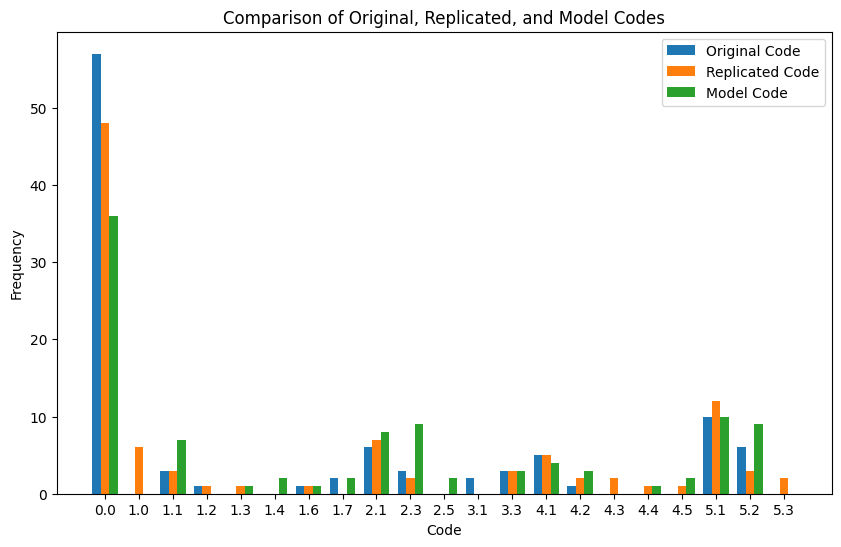

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame with 'original_code', 'replicated_code', and 'model_code' columns
data = df.copy()

# Check if data contains valid columns
if 'original_code' in data.columns and 'replicated_code' in data.columns and 'model_code' in data.columns:
    
    # Define the categories that you want to use as bins (ensure you cover all possible values in the dataset)
    code_categories = sorted(set(data['original_code'].unique()).union(
                             set(data['replicated_code'].unique())).union(
                             set(data['model_code'].unique())))

    # Generate counts for each code, reindex to ensure all categories are present
    original_counts = data['original_code'].value_counts().reindex(code_categories, fill_value=0)
    replicated_counts = data['replicated_code'].value_counts().reindex(code_categories, fill_value=0)
    model_counts = data['model_code'].value_counts().reindex(code_categories, fill_value=0)

    # Debugging: Print the counts to ensure they are correct
    print("Original Counts:\n", original_counts)
    print("Replicated Counts:\n", replicated_counts)
    print("Model Counts:\n", model_counts)

    # Set positions for bars
    bar_width = 0.25
    index = np.arange(len(code_categories))

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Bar plots
    plt.bar(index, original_counts, bar_width, label='Original Code')
    plt.bar(index + bar_width, replicated_counts, bar_width, label='Replicated Code')
    plt.bar(index + 2 * bar_width, model_counts, bar_width, label='Model Code')

    # Add labels and title
    plt.xlabel('Code')
    plt.ylabel('Frequency')
    plt.title('Comparison of Original, Replicated, and Model Codes')
    plt.xticks(index + bar_width, code_categories)
    plt.legend()

    # Display the plot
    plt.show()
else:
    print("Data does not contain the required columns.")


In [11]:
import os
import re
import time
import requests
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Together API endpoint and key
ENDPOINT = 'https://api.together.xyz/inference'
TOGETHER_API_KEY = os.getenv('TOGETHER_API_KEY')

if not TOGETHER_API_KEY:
    raise ValueError("TOGETHER_API_KEY not found in environment variables")

# Maintain original codebook
CODEBOOK = {
    "1.1": "Ice/permafrost/snow cover isn't melting",
    "1.2": "We're heading into an ice age/global cooling",
    "1.3": "Weather is cold/snowing",
    "1.4": "Climate hasn't warmed/changed over the last (few) decade(s)",
    "1.5": "Oceans are cooling/not warming",
    "1.6": "Sea level rise is exaggerated/not accelerating",
    "1.7": "Extreme weather isn't increasing/has happened before/isn't linked to climate change",
    "1.8": "They changed the name from 'global warming' to 'climate change'",
    "2.1": "It's natural cycles/variation",
    "2.2": "It's non-greenhouse gas human climate forcings (aerosols, land use)",
    "2.3": "There's no evidence for greenhouse effect/carbon dioxide driving climate change",
    "2.4": "CO2 is not rising/ocean pH is not falling",
    "2.5": "Human CO2 emissions are miniscule/not raising atmospheric CO2",
    "3.1": "Climate sensitivity is low/negative feedbacks reduce warming",
    "3.2": "Species/plants/reefs aren't showing climate impacts yet/are benefiting from climate change",
    "3.3": "CO2 is beneficial/not a pollutant",
    "3.4": "It's only a few degrees (or less)",
    "3.5": "Climate change does not contribute to human conflict/threaten national security",
    "3.6": "Climate change doesn't negatively impact health",
    "4.1": "Climate policies (mitigation or adaptation) are harmful",
    "4.2": "Climate policies are ineffective/flawed",
    "4.3": "It's too hard to solve",
    "4.4": "Clean energy technology/biofuels won't work",
    "4.5": "People need energy (e.g., from fossil fuels/nuclear)",
    "5.1": "Climate-related science is uncertain/unsound/unreliable (data, methods & models)",
    "5.2": "Climate movement is alarmist/wrong/political/biased/hypocritical (people or groups)",
    "5.3": "Climate change (science or policy) is a conspiracy (deception)",
    "0.0": "None of the above"
}

def prepare_prompt(text):
    system_prompt = f"""
    You are a qualitative coder who is annotating conservative blog posts related to climate change.
    To code this text, do the following:
    - First, read the codebook and the text.
    - Next, decide which code is most applicable and explain your reasoning for the coding
    decision.
    - Finally, print the most applicable code and your reason for the coding decision.
    Use the following format:
    Codebook:
    ---
    {CODEBOOK}
    ---
    Text:
    ---
    {text}
    ---
    Code:
    """
    return system_prompt

def classify_text(text, retry_count=3, retry_delay=1):
    """Classify text with improved error handling and retry logic."""
    headers = {
        "Authorization": f"Bearer {TOGETHER_API_KEY}",
        "Content-Type": "application/json"
    }
    
    data = {
        "model": "meta-llama/Llama-3-70b-chat-hf",
        "prompt": prepare_prompt(text),
        "max_tokens": 500,
        "temperature": 0.8,  # Maintaining original temperature
        "top_p": 1,
        "top_k": 40,
        "repetition_penalty": 1
    }
    
    for attempt in range(retry_count):
        try:
            response = requests.post(ENDPOINT, json=data, headers=headers)
            response.raise_for_status()
            
            response_data = response.json()
            
            # Handle different response formats
            if 'output' in response_data:
                if isinstance(response_data['output'], dict):
                    output = response_data['output'].get('choices', [{}])[0].get('text', '')
                else:
                    output = response_data['output'].get('text', '')
            else:
                raise ValueError("Unexpected API response format")
            
            if not output:
                raise ValueError("Empty response from API")
            
            # First look for a code in a more structured format
            code_match = re.search(r'Code:[\s\n]*([0-9]+\.[0-9]+|0\.0)', output, re.IGNORECASE)
            
            # If not found, look for a code at the start of a line or in quotes
            if not code_match:
                code_match = re.search(r'(?:^|\n|\s|\'|")([0-9]+\.[0-9]+|0\.0)(?:\s|$|\'|")', output, re.IGNORECASE)
            
            # If still not found, look for "code" followed by a number within reasonable proximity
            if not code_match:
                code_match = re.search(r'(?i)code\s+(?:is|:|=|\s)\s*([0-9]+\.[0-9]+|0\.0)', output)
            
            code = code_match.group(1) if code_match else "0.0"
            
            # Extract reasoning
            reasoning_match = re.search(r'Reason(?:ing)?:[\s\n]*(.+)$', output, re.IGNORECASE | re.DOTALL)
            if not reasoning_match:
                reasoning_match = re.search(r'because(.+)$', output, re.IGNORECASE | re.DOTALL)
            
            reasoning = reasoning_match.group(1).strip() if reasoning_match else output.strip()
            
            return code, reasoning
            
        except (requests.exceptions.RequestException, ValueError) as e:
            if attempt == retry_count - 1:
                return "Error", f"API request failed after {retry_count} attempts: {str(e)}"
            time.sleep(retry_delay * (2 ** attempt))  # Exponential backoff
        
        except Exception as e:
            return "Error", f"Processing failed: {str(e)}"
    
    return "Error", "Maximum retries exceeded"

def process_dataframe(df, batch_size=100, save_interval=500):
    """Process the dataframe with improved progress tracking and error handling."""
    df_processed = df.copy()
    
    # Initialize columns if they don't exist
    for col in ['model_prediction', 'reasoning']:
        if col not in df_processed.columns:
            df_processed[col] = None
    
    # Get unprocessed rows
    unprocessed_mask = df_processed['model_prediction'].isna()
    total_unprocessed = unprocessed_mask.sum()
    
    if total_unprocessed == 0:
        print("All rows have already been processed!")
        return df_processed
    
    print(f"Processing {total_unprocessed} unprocessed rows...")
    
    try:
        with tqdm(total=total_unprocessed) as pbar:
            for idx in df_processed[unprocessed_mask].index:
                try:
                    text = df_processed.loc[idx, 'text']
                    code, reasoning = classify_text(text)
                    
                    df_processed.loc[idx, 'model_prediction'] = code
                    df_processed.loc[idx, 'reasoning'] = reasoning
                    
                    pbar.update(1)
                    
                    # Save intermediate results
                    if (pbar.n % save_interval) == 0:
                        df_processed.to_csv('intermediate_results.csv', index=False)
                    
                    # Rate limiting pause
                    if (pbar.n % batch_size) == 0:
                        time.sleep(1)
                        
                except Exception as e:
                    print(f"\nError processing row {idx}: {str(e)}")
                    continue
                    
    except KeyboardInterrupt:
        print("\nProcessing interrupted by user. Saving current progress...")
    
    finally:
        # Save final results
        df_processed.to_csv('contrarian.csv', index=False)
        
        # Print summary
        success_mask = df_processed['model_prediction'].notna() & ~df_processed['model_prediction'].eq('Error')
        success_count = success_mask.sum()
        error_count = df_processed['model_prediction'].eq('Error').sum()
        
        print("\nProcessing summary:")
        print(f"Successfully processed: {success_count} rows")
        print(f"Errors: {error_count} rows")
    
    return df_processed

In [12]:
import pandas as pd

# Create a sample dataframe with 5 rows
sample_data = {
    'text': [
        "Despite what alarmists say, the recent cold snap proves global warming is a hoax. It's snowing more than ever!",
        
        "Climate change is just part of Earth's natural cycle. We've had warm periods and ice ages throughout history, long before humans started burning fossil fuels.",
        
        "Scientists keep adjusting their data and models. First it was global warming, now it's climate change. They can't make up their minds!",
        
        "Green energy is a joke. Wind turbines kill birds and solar panels don't work when it's cloudy. We need reliable fossil fuels for our economy.",
        
        "CO2 is plant food! Higher CO2 levels are actually making the Earth greener and helping crops grow better. This is basic science."
    ]
}

# Create the dataframe
#df = pd.DataFrame(sample_data)

# Run the classifier on the sample data
results = process_dataframe(df)

# Display the results in a more readable format
pd.set_option('display.max_colwidth', None)  # Show full text content
print("\nDetailed Classification Results:")
print("-" * 80)
for idx, row in results.iterrows():
    print(f"Text {idx + 1}:")
    print(f"Content: {row['text']}")
    print(f"Code: {row['model_prediction']}")
    print(f"Reasoning: {row['reasoning']}")
    print("-" * 80)

Processing 100 unprocessed rows...


100%|██████████| 100/100 [03:48<00:00,  2.29s/it]


Processing summary:
Successfully processed: 100 rows
Errors: 0 rows

Detailed Classification Results:
--------------------------------------------------------------------------------
Text 1:
Content: The Food and Drug Administrations seeks input about online advertising of drugs and other medical products.
Code: 0.0
Reasoning: 0.0
    Reason for coding decision:
    The text does not mention climate change at all, so none of the above codes are applicable.
--------------------------------------------------------------------------------
Text 2:
Content: Has the globe warmed? Most think that since the late 19th century, there has been some warming. The issue becomes muddled when you consider such factors as the reliability of the data sets, the selective use of the proxy data used to estimate historic temperatures and the way urbanization warms local weather stations.
Code: 1.4
Reasoning: The text seems to be saying that it is difficult to determine whether the Earth has warmed or not b

In [14]:
df2 = pd.read_csv('contrarian.csv')

In [16]:
# Categories for the x-axis
categories = sorted(set(results['original_code']) | set(results['replicated_code']) | 
                   set(results['model_code']) | set(results['model_prediction']))

# Get value counts for each column, reindex to include all categories
original_code_counts = results['original_code'].value_counts().reindex(categories).fillna(0)
replicated_code_counts = results['replicated_code'].value_counts().reindex(categories).fillna(0)
model_code_counts = results['model_code'].value_counts().reindex(categories).fillna(0)
model_predictions_counts = results['model_prediction'].value_counts().reindex(categories).fillna(0)

# Number of categories
n = len(categories)

# Create a range for the x-axis based on the number of categories
x = np.arange(n)

# Set the width of the bars (adjusted for 4 bars)
width = 0.2  # Made smaller to accommodate 4 bars

# Create the plot
plt.figure(figsize=(12, 6))  # Made wider to accommodate 4 bars

# Create bars with adjusted positions
plt.bar(x - 1.5*width, original_code_counts, width, label='Original Code', color='#2ecc71')
plt.bar(x - 0.5*width, replicated_code_counts, width, label='Replicated Code', color='#3498db')
plt.bar(x + 0.5*width, model_code_counts, width, label='Model Code', color='#e74c3c')
plt.bar(x + 1.5*width, model_predictions_counts, width, label='Predicted Code', color='#9b59b6')

# Add labels, title, and custom x-axis tick labels
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Comparison of Codes Across Four Columns', fontsize=14)
plt.xticks(x, categories, rotation=45)

# Add value labels on top of each bar
for i in range(n):
    plt.text(x[i] - 1.5*width, original_code_counts[i] + 0.5, str(int(original_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] - 0.5*width, replicated_code_counts[i] + 0.5, str(int(replicated_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] + 0.5*width, model_code_counts[i] + 0.5, str(int(model_code_counts[i])), 
             ha='center', va='bottom')
    plt.text(x[i] + 1.5*width, model_predictions_counts[i] + 0.5, str(int(model_predictions_counts[i])), 
             ha='center', va='bottom')

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

TypeError: '<' not supported between instances of 'str' and 'float'